## TP2 : Classification using Linear & Quadratic Discriminant Analysis

First think of configuring your notebook :

In [1]:
import csv
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
import seaborn as sns 

## Reading synthetic data
Load the training and test data sets |synth_train.txt| and
|synth_test.txt| already used for Knn. Targets belong to {1,2} and entries belong to R^2.
We have 100 training data samples and 200 test samples.

* the 1st column contains the label of the class the sample, 
* columns 2 & 3 contain the coordinates of each sample in 2D.

In [2]:
train = np.loadtxt('synth_train.txt')

test = np.loadtxt('synth_test.txt')

## Recall about the main steps of discriminant analysis:
* estimation of weights `pi_1` and `pi_2` for each class,
* estimation of empirical means `mu_1` and `mu_2` for each class, 
* estimation of empirical covariance matrices  `sigma_1` and `sigma_2`,
* computation of the common averaged covariance `sigma` (average of intra-class covariances),
* computation of log-probabilities of belonging to each class,
* decision of classification,
* display results.


## TO DO : linear & quadratic discriminant analysis (LDA & QDA)
1. Implement a classifier using LDA of the data set. 
2. Then implement QDA classification.
3. In each case (LDA & QDA) show the decision boundary and
compute the error rate respectively for the training set and the test set. 
4. Compare and comment on your results with LDA and QDA.
5. You may also compare your results to K nearest neighbours.

_Indication  : matrices `sigma` are of size 2x2.
More generally, be careful of the sizes of vectors and matrices you
manipulate._



In this question, we propose to break the code in various Jupyter code units to make the code more readable and understandable

**PART 1 - LDA CLASSIFIER**

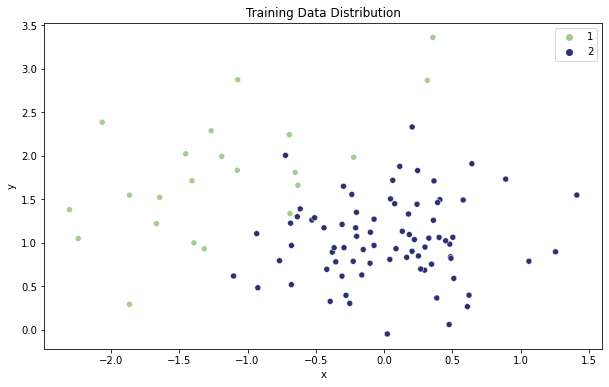

In [3]:
# Separate features and labels
X_train, Labels_train = train[:, 1:], train[:, 0].astype(int)
X_test, Labels_test = test[:, 1:], test[:, 0].astype(int)

# Training data
plt.figure(figsize=(10, 6))
X = [X_train[i][0] for i in range(len(X_train))]
Y = [X_train[i][1] for i in range(len(X_train))]
sns.scatterplot(x=X, y=Y, hue=Labels_train, palette="crest")
plt.title('Training Data Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
# Calculate weights, empirical means, and empirical covariance matrix
def LDA_param(X_data, labels):
    classes = np.unique(labels)
    weights = np.array([np.mean(labels == cls) for cls in classes])
    means = np.array([X_data[labels == cls].mean(axis=0) for cls in classes])  
    cov = sum([(X_data[labels == cls] - means[i]).T @ (X_data[labels == cls] - means[i]) / len(labels) for i, cls in enumerate(classes)])
    return weights, means, cov

weights_lda, means_lda, cov_lda = LDA_param(X_train,Labels_train)
print(f"Parameters of LDA for the train set:\n\nWeights: {weights_lda}\nMeans: {means_lda}\nCovariance: {cov_lda}")
# LDA : single covariance matrix ie dim(1,1)

Parameters of LDA for the train set:

Weights: [0.22 0.78]
Means: [[-1.18350693  1.78655437]
 [ 0.02868973  1.04424548]]
Covariance: 0.7389398389865374


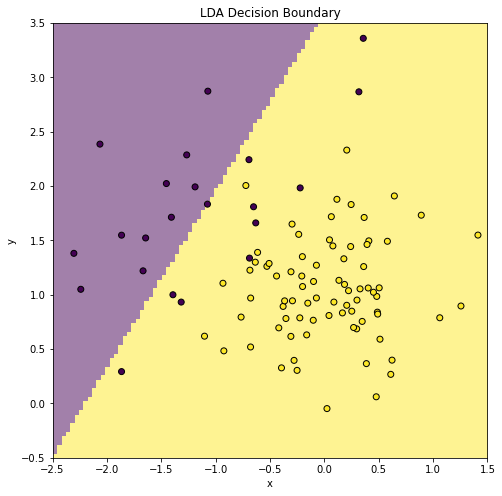

In [5]:
# LDA Classifier
def lda_predict(X_data, weights, means, cov):
    inv_cov = cov**(-1) # Because cov is a scalar
    scores = []
    for i, mean in enumerate(means):
        # To calculate every decision boundary function
        diff = X_data - mean # (X - mu) in our formula
        score = np.log(weights[i]) - 0.5 * np.sum(diff * inv_cov * diff, axis=1) - 0.5 * np.log(np.abs(cov)) # Because cov is a scalar
        scores.append(score)
    scores = np.vstack(scores).T
    predictions = np.argmax(scores, axis=1) + 1 
    return predictions
    
# Create mesh grid
Nx1, Nx2 = 100, 100
x1_vals = np.linspace(-2.5, 1.5, Nx1)
x2_vals = np.linspace(-0.5, 3.5, Nx2)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid_points = np.c_[X1.ravel(), X2.ravel()]

# Predict on grid for visualization
grid_preds_lda = lda_predict(grid_points, weights_lda, means_lda, cov_lda)
plt.imshow(grid_preds_lda.reshape(Nx1, Nx2), extent=(x1_vals.min(), x1_vals.max(), x2_vals.min(), x2_vals.max()), origin='lower', alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Labels_train, edgecolor='k', marker='o')
plt.gcf().set_size_inches((8, 8))   
plt.title("LDA Decision Boundary")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
# Calculate error rates
Labels_train_pred_lda = lda_predict(X_train, weights_lda, means_lda, cov_lda)
Labels_test_pred_lda = lda_predict(X_test, weights_lda, means_lda, cov_lda)

train_error_lda = np.mean(Labels_train_pred_lda != Labels_train)
test_error_lda = np.mean(Labels_test_pred_lda != Labels_test)
print(f"LDA Train Error: {train_error_lda*100:.1f}% \nLDA Test Error: {test_error_lda*100:.1f}%")

LDA Train Error: 11.0% 
LDA Test Error: 13.0%


The small increase in error from training to testing (from 11% to 14.5%) suggests that the model generalizes reasonably well to unseen data. -> Not Overfitting

The error rates suggest that the data might not fully satisfy the gaussian distribution for each class hypothesis (11% and 14,5% > 5%). Hence it is convenient to test the QDA classifier (or KNN)

**PART 2 - QDA CLASSIFIER**

In [7]:
# Calculate weights, means, and class-specific covariance matrices
def QDA_param(X_data, Labels):
    classes = np.unique(Labels)
    weights = np.array([np.mean(Labels == cls) for cls in classes])
    means = np.array([X_data[Labels == cls].mean(axis=0) for cls in classes]) 
    covs = np.array([np.cov(X_data[Labels == cls].T) for cls in classes])
    return weights, means, covs

weights_qda, means_qda, covs_qda = QDA_param(X_train, Labels_train)
print(f"Parameters of QDA for the train set:\n\nWeights: {weights_qda}\nMeans: {means_qda}\nCovariances: {covs_qda}")

Parameters of QDA for the train set:

Weights: [0.22 0.78]
Means: [[-1.18350693  1.78655437]
 [ 0.02868973  1.04424548]]
Covariances: [[[0.54124863 0.32258376]
  [0.32258376 0.51088153]]

 [[0.24599115 0.01961141]
  [0.01961141 0.21154879]]]


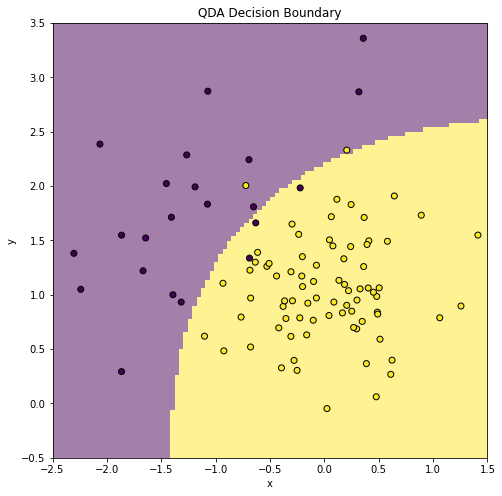

In [8]:
def qda_predict(X_data, weights, means, covs):
    num_classes = len(weights)
    num_samples = X_data.shape[0]
    scores = np.zeros((num_samples, num_classes))

    for i in range(num_classes):
        # To calculate every decision boundary function
        mean = means[i]
        cov = covs[i]
        inv_cov = la.inv(cov)
        det_cov = la.det(cov)
        diff = X_data - mean # (X - mu) in our formula
        scores[:, i] = np.log(weights[i]) - 0.5 * np.log(det_cov) - 0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    predictions = np.argmax(scores, axis=1) + 1 # Choose the class with the highest score for each sample
    return predictions

# Create mesh grid
Nx1, Nx2 = 100, 100
x1_vals = np.linspace(-2.5, 1.5, Nx1)
x2_vals = np.linspace(-0.5, 3.5, Nx2)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid_points = np.c_[X1.ravel(), X2.ravel()]

# Predict on grid for visualization
grid_preds_qda = qda_predict(grid_points, weights_qda, means_qda, covs_qda)
plt.imshow(grid_preds_qda.reshape(Nx1, Nx2), extent=(x1_vals.min(), x1_vals.max(), x2_vals.min(), x2_vals.max()), origin='lower', alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Labels_train, edgecolor='k', marker='o')
plt.gcf().set_size_inches((8, 8))   
plt.title("QDA Decision Boundary")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
# Calculate error rates
Labels_train_pred_qda = qda_predict(X_train, weights_qda, means_qda, covs_qda)
Labels_test_pred_qda = qda_predict(X_test, weights_qda, means_qda, covs_qda)

train_error_qda = np.mean(Labels_train_pred_qda != Labels_train)
test_error_qda = np.mean(Labels_test_pred_qda != Labels_test)
print(f"QDA Train Error: {train_error_qda*100:.1f}% \nQDA Test Error: {test_error_qda*100:.1f}%")

QDA Train Error: 5.0% 
QDA Test Error: 5.0%


The error similarity between training to testing (to 5%) suggests that the model generalizes reasonably well to unseen data. -> Not Overfitting

The error rates suggest that the data might fully satisfy QDA classifier hypothesis (error <= 5%). Hence the QDA classifier is here pretty suitable.

The significantly lower error rate compared to LDA suggests that QDA’s assumptions (class-specific covariances) are more compatible with the data. This makes QDA a better choice for this problem.

**COMPARING LDA AND QDA**

**PART 3 - KNN**

In [10]:
def knn_predict(X_train, Labels_train, X_test, k):
    predictions = []
    for test_point in X_test:
        distances = np.sqrt(np.sum((X_train - test_point) ** 2, axis=1))
        nearest_neighbor_ids = distances.argsort()[:k]
        nearest_labels = Labels_train[nearest_neighbor_ids]
        label = np.bincount(nearest_labels).argmax()
        predictions.append(label)
    return np.array(predictions)

k = 4
Labels_train_pred_knn = knn_predict(X_train, Labels_train, X_train, k)
Labels_test_pred_knn = knn_predict(X_test, Labels_test, X_test, k)

# Calculating error rates
train_error_knn = np.mean(Labels_train_pred_knn != Labels_train)
test_error_knn = np.mean(Labels_test_pred_knn != Labels_test)

print(f"KNN Train Error (K={k}): {train_error_knn*100:.1f}% \nKNN Test Error (K={k}): {test_error_knn*100:.1f}%")

KNN Train Error (K=4): 3.0% 
KNN Test Error (K=4): 4.0%


KNN performs very well on this dataset with low error rates on both training and test sets (Errors < 5%). Given that KNN’s test error is lower than both LDA and QDA, KNN could be considered the most suitable model for this classification problem.

With $k$ = 4 we have chosen a relatively small neighborhood size, which allows KNN to capture more local details in the data. Larger values of $k$ would smooth out the decision boundary more, which might increase the test error. As examplified below : 

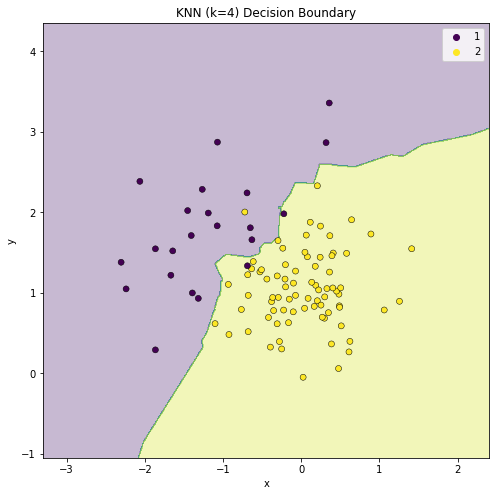

KNN Train Error (K=4): 3.0% 
KNN Test Error (K=4): 4.0%


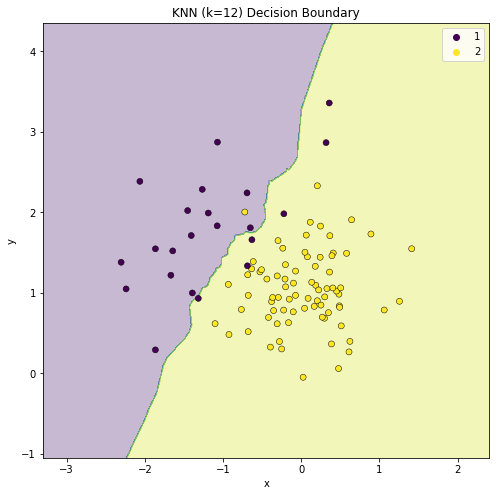

KNN Train Error (K=12): 7.0% 
KNN Test Error (K=12): 4.5%


In [11]:
def plot_decision_boundary(predict_func, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_func(grid)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', edgecolor='k')
    plt.gcf().set_size_inches((8, 8)) 
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# KNN decision boundary K = 4
k = 4
plot_decision_boundary(lambda X: knn_predict(X_train, Labels_train, X, k=4), X_train, Labels_train, 'KNN (k=4) Decision Boundary')
print(f"KNN Train Error (K={k}): {train_error_knn*100:.1f}% \nKNN Test Error (K={k}): {test_error_knn*100:.1f}%")

# KNN decision boundary K = 12
k = 12
Labels_train_pred_knn = knn_predict(X_train, Labels_train, X_train, k)
Labels_test_pred_knn = knn_predict(X_test, Labels_test, X_test, k)
# Calculating error rates
train_error_knn = np.mean(Labels_train_pred_knn != Labels_train)
test_error_knn = np.mean(Labels_test_pred_knn != Labels_test)
plot_decision_boundary(lambda X: knn_predict(X_train, Labels_train, X, k=12), X_train, Labels_train, 'KNN (k=12) Decision Boundary')
print(f"KNN Train Error (K={k}): {train_error_knn*100:.1f}% \nKNN Test Error (K={k}): {test_error_knn*100:.1f}%")

**Overall, KNN provides the best test performance here, followed closely by QDA, which supports the idea that non-parametric models work well for this data**

## TO DO : LDA & QDA using scikit-learn module

The module `scikit-learn` is dedicated to machine learning algorithms. Many of them are available in a simple manner. For LDA and QDA, have a look at the tutorial available at http://scikit-learn.org/stable/modules/lda_qda.html 

**Warning** : you may have a critical view of the way LDA and QDA are illustrated in the proposed example...




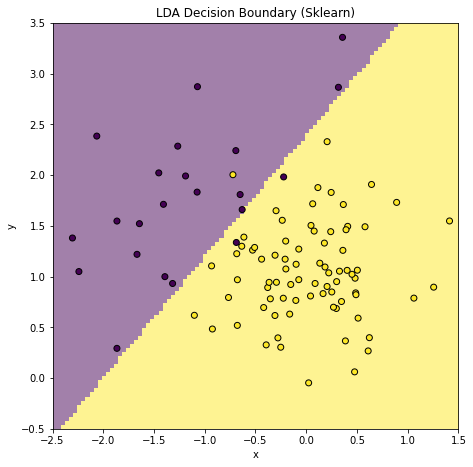

Sklearn LDA Train Error: 3.0% 
Sklearn LDA Test Error: 5.5%


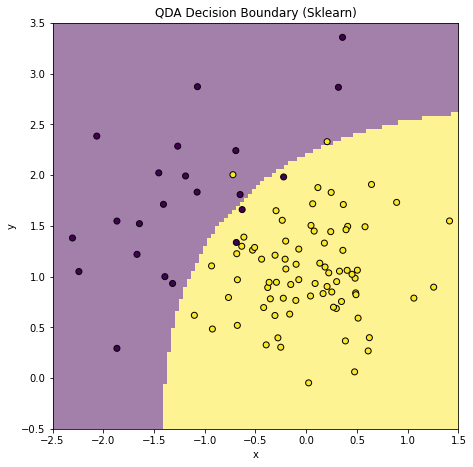

Sklearn QDA Train Error: 5.0% 
Sklearn QDA Test Error: 5.0%


In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# LDA using scikit-learn
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, Labels_train)
train_error_sklearn_lda = 1 - lda_model.score(X_train, Labels_train)
test_error_sklearn_lda = 1 - lda_model.score(X_test, Labels_test)

# QDA using scikit-learn
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, Labels_train)
train_error_sklearn_qda = 1 - qda_model.score(X_train, Labels_train)
test_error_sklearn_qda = 1 - qda_model.score(X_test, Labels_test)

# Create mesh grid
Nx1, Nx2 = 100, 100
x1_vals = np.linspace(-2.5, 1.5, Nx1)
x2_vals = np.linspace(-0.5, 3.5, Nx2)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid_points = np.c_[X1.ravel(), X2.ravel()]

# Predicts
lda_grid_preds = lda_model.predict(grid_points)
qda_grid_preds = qda_model.predict(grid_points)

# LDA Decision Boundary Plot
plt.subplot(1, 2, 1)
plt.imshow(lda_grid_preds.reshape(Nx1, Nx2), extent=(x1_vals.min(), x1_vals.max(), x2_vals.min(), x2_vals.max()), origin='lower', alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Labels_train, edgecolor='k', marker='o')
plt.gcf().set_size_inches((16, 16))    
plt.title("LDA Decision Boundary (Sklearn)")
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(f"Sklearn LDA Train Error: {train_error_sklearn_lda*100:.1f}% \nSklearn LDA Test Error: {test_error_sklearn_lda*100:.1f}%")

# QDA Decision Boundary Plot
plt.subplot(1, 2, 2)
plt.imshow(qda_grid_preds.reshape(Nx1, Nx2), extent=(x1_vals.min(), x1_vals.max(), x2_vals.min(), x2_vals.max()), origin='lower', alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Labels_train, edgecolor='k', marker='o')
plt.gcf().set_size_inches((16, 16))   
plt.title("QDA Decision Boundary (Sklearn)")
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(f"Sklearn QDA Train Error: {train_error_sklearn_qda*100:.1f}% \nSklearn QDA Test Error: {test_error_sklearn_qda*100:.1f}%")

**Conclusion**

The sklearn predictions likely demonstrate LDA and QDA in idealized conditions. A critical view would recognize that while these examples show how to implement LDA and QDA, they may not highlight situations where the assumptions of each model are violated. Examples in sklearn may not highlight situations where non-parametric methods, like KNN, outperform LDA and QDA. KNN makes fewer assumptions.

QDA appears to be the more suitable model for this dataset, as it achieves a low error on test sets even though LDA errors are much lower with sklearn than our code.

The sklearn examples illustrate LDA and QDA on small datasets, where these models can easily perform well. However, as datasets grow in complexity, the assumptions of LDA and QDA might lead to non optimal results. In particular, QDA might struggle with high-dimensional data (covariance matrix for each class)